# Comparing Simulators Performances


In previous notebook I implemented a simulator of BC model.

However, this creates problems in the update of X when a node interact more than once at the same time, because it updates only one interaction.
Moreover, we need to ensure that updating more than once at the same time does not cause the opinion to go out of the bounds [0,1] of the opinion space.

Hence, in this notebook we compare three approaches:
- sparse tensor: we write the edges at time t as a sparse adjacency tensor NxN, multiply it by the matrix of opinion differences, and update X by summing the rows/columns of the opinion differences of the interacting nodes. At each step we update the opinino difference matrix
- for cycle: instead of writing X[u] += mu * diff_X * s, we write a for cycle on the u (and v)
- hybrid for: we apply the for cycle only when a node interact more than once at time t

In [ ]:
from torch.distributions import Beta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path += ["/home/jacopo.lenti/Projects/learning-od-step-by-step/src"]
import simulator_BC_evidences as sim_bc_e
import pandas as pd
import torch
import importlib
from tqdm import tqdm
from time import time
from scipy.sparse import coo_array
from scipy.special import expit as sigmoid

In [2]:
N, T, edge_per_t = 100, 200, 5
epsilon = 0.4
epsilon0 = 0.25
mu = 0.12
rho = 70

X, edges = sim_bc_e.simulator_BC_evidence(N,T,edge_per_t,epsilon,mu)

## Simulator with scipy sparse

### Update from X[0] to X[1]

In [83]:
X0 = np.random.random(N)
diff_X_np = X0[:,None] - X0[None,:]

X = X0.copy()

In [84]:
np_u, np_v = np.random.choice(N, size = [2, edge_per_t])

In [85]:
np_s = (np.random.random(edge_per_t) < sigmoid(rho * (epsilon - np.abs(diff_X_np[np_u,np_v])))) + 0.

In [86]:
diff_X_uv = coo_array((diff_X_np[np_u, np_v] * np_s, (np_u, np_v)), shape = (N, N))

In [87]:
updates = mu * (diff_X_uv.sum(axis = 0) - diff_X_uv.sum(axis = 1))
X += updates

In [88]:
diff_X_np = ((diff_X_np + updates).T - updates).T

### BC Simulator

In [90]:
print(X[np_u])
print(X[np_v])

diff_X_uv.row, diff_X_uv.col, diff_X_uv.data, diff_X_uv.sum(axis = 0) - diff_X_uv.sum(axis = 1)

[0.34848764 0.60726604 0.88331219 0.18967337 0.46374995]
[0.12662293 0.61164528 0.80027675 0.67786542 0.96417826]


(array([67, 31, 80, 32, 81], dtype=int32),
 array([85, 40,  7, 70, 59], dtype=int32),
 array([ 0.29192725, -0.00576215,  0.10925717, -0.        , -0.        ]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.10925717,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00576215,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.00576215,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0

In [257]:
def simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, 
                     with_evidences = False, sum_ab = 1,
                     rho = 70, seed = None, X0 = [], evidences_per_t = None, as_torch = True):
    if seed != None:
        np.random.seed(seed)


    if len(X0) == 0:
        X0 = np.random.random(N)

    edges, evidences, X = [], [], []

    t = 0
    X_t = X0.copy() #all opinions of the users
    diff_X = X0[:,None] - X0[None,:]
    X.append(X_t)


    for t in range(T - 1):
        u,v = np.random.choice(N, size = [2, edge_per_t])
        s = (np.random.random(edge_per_t) < sigmoid(rho * (epsilon - np.abs(diff_X[u,v])))) + 0.
        
        diff_X_uv = coo_array((diff_X[u, v] * s, (u, v)), shape = (N, N))
        
        new_X_t = X_t.copy()
        
        updates = mu * (diff_X_uv.sum(axis = 0) - diff_X_uv.sum(axis = 1))
        new_X_t += updates
        
        #if (new_X_t.min() < 0.) or (new_X_t.max() > 1):
        #    new_X_t = np.clip(new_X_t, a_min = 0., a_max = 1.)
        #    diff_X = new_X_t[:,None] - new_X_t[None,:]
        #else:
        #    diff_X = ((diff_X - updates).T + updates).T
        diff_X = new_X_t[:,None] - new_X_t[None,:]
        X.append(new_X_t)
        
        X_t = new_X_t.copy()
        edges.append([u,v,s])
        
        
    if as_torch:
        X = torch.from_numpy(np.array(X))
        edges = torch.from_numpy(np.array(edges)).permute(2,0,1)
        evidences = torch.from_numpy(np.array(evidences))    

    if with_evidences:
        if with_evidences:
            evidences = Beta(sum_ab * X + 1e-7, sum_ab * (1 - X) + 1e-7).sample()
            sampled_evidences = [(u, evidences[t, u]) for t in range(T) 
                                 for u in torch.randint(low = 0, high = N, size = [1, evidences_per_t])]
         
        return X, edges, evidences
    else:
        return X, edges
    


In [264]:
t0 = time()
X, edges, evidences = simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, 
                        with_evidences = True, sum_ab = 1,
                        rho = 70, seed = None, X0 = [], evidences_per_t = 10)
t1 = time()
print(t1-t0)
t0 = time()
X, edges, _ = sim_bc_e.simulator_BC_evidence(N, T, edge_per_t, epsilon, mu, 
                                          with_evidences = True, sum_ab = 1,
                                          rho = 70, seed = None, X0 = [], evidences_per_t = 10)
t1 = time()
print(t1-t0)

0.0670936107635498
0.12251806259155273


In [244]:
#op[nodes]
op[0, nodes[0]]

tensor([2.4461e-11, 4.6080e-01, 5.9033e-01, 4.8782e-02, 9.9999e-01, 6.5370e-01,
        1.2236e-02, 9.9957e-01, 7.4703e-01, 2.6033e-01], dtype=torch.float64)

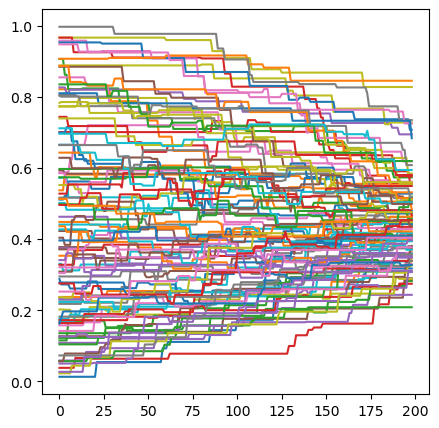

In [132]:
sim_bc_e.print_opinion_trajectory(X)


## Simulator with sparse tensors

### Update from X[0] to X[1]

In [5]:
t = 0

edge_t = edges[t]

In [16]:
u,v,s = edge_t.T

In [252]:
u_sparse = torch.sparse_coo_tensor(torch.cat([u[None,:], torch.zeros(1,edge_per_t)]), s, (N,1)).float()
u_sparse_T = torch.sparse_coo_tensor(torch.cat([torch.zeros(1,edge_per_t), u[None,:]]), s, (1,N)).float()

v_sparse = torch.sparse_coo_tensor(torch.cat([v[None,:], torch.zeros(1,edge_per_t)]), s, (N,1)).float()
v_sparse_T = torch.sparse_coo_tensor(torch.cat([torch.zeros(1,edge_per_t), v[None,:]]), s, (1,N)).float()

In [258]:
u_sparse_diag = torch.sparse_coo_tensor(torch.cat([u[None,:], u[None,:]]), s, (N,N)).float()
v_sparse_diag = torch.sparse_coo_tensor(torch.cat([v[None,:], v[None,:]]), s, (N,N)).float()

diff_X_uv = torch.sparse.mm(v_sparse_diag,  torch.sparse.mm(u_sparse_diag, (X[0, :, None] - X[0, None, :])).T)

(X[0] + mu * diff_X_uv.sum(dim = 1) - mu * diff_X_uv.sum(dim = 0)) - X[1] 

### Update from X[0] to X[tk]

In [307]:
tk = 20
Y = X[0].clone()[None,:]

for t in range(tk):
    edge_t = edges[t]
    u,v,s = edge_t.T
    
    u_sparse_diag = torch.sparse_coo_tensor(torch.cat([u[None,:], u[None,:]]), s, (N,N)).float()
    v_sparse_diag = torch.sparse_coo_tensor(torch.cat([v[None,:], v[None,:]]), s, (N,N)).float()
    
    diff_Y_uv = torch.sparse.mm(v_sparse_diag,  torch.sparse.mm(u_sparse_diag, (Y[t, :, None] - Y[t, None, :])).T)
    
    Y = torch.cat([Y, (Y[t] + (mu * diff_Y_uv.sum(dim = 1) - mu * diff_Y_uv.sum(dim = 0)))[None,:]], dim = 0)
    
    if torch.abs(torch.sum(Y[t] - X[t])) != 0:
        break

### BC Simulator

In [344]:
def simulator_BC_coo(N, T, edge_per_t, epsilon, mu, 
                     with_evidences = False, sum_ab = 1,
                     rho = 70, seed = None, X0 = [], evidences_per_t = None):
    if seed != None:
        torch.manual_seed(seed)

    if len(X0) == 0:
        X0 = torch.rand(N)

    edges = torch.empty([0, edge_per_t, 3], dtype = torch.long)
    evidences = torch.empty([0, N])

    t = 0
    X = X0.clone()[None,:] #all opinions of the users


    for t in range(T - 1):
        X_t = X[-1, :].clone()
        u,v = torch.randint(low = 0, high = N, size = [2, edge_per_t])

        diff_X_values = X_t[u] - X_t[v]
        
        s_t = torch.rand(edge_per_t) < torch.sigmoid(rho * (epsilon - torch.abs(diff_X_values)))
        
        #diff_X_uv = torch.sparse.mm(v_sparse_diag,  torch.sparse.mm(u_sparse_diag, (X_t[:, None] - X[None, :])).T)
        
        diff_X_matrix = torch.sparse_coo_tensor(torch.cat([u[None,:],v[None,:]]), X[0,u] - X[0,v], (N,N))
        
        
        
        X_t += mu * torch.sparse.sum(diff_X_matrix, dim = 1) - mu * torch.sparse.sum(diff_X_matrix, dim = 0)
        
        #X_t[u[s_t]] -= mu * diff_X[s_t]
        #X_t[v[s_t]] += mu * diff_X[s_t]

        X = torch.cat([X, X_t[None, :]], dim = 0)

        edges_t = torch.cat([u.long()[:, None], v.long()[:, None], s_t.long()[:, None]], dim = 1)
        edges = torch.cat([edges,  edges_t[None, :, :]])
    
    X = torch.clamp(X, min = 0., max = 1.)
    
    if with_evidences:
        evidences = Beta(sum_ab * X + 1e-7, sum_ab * (1 - X) + 1e-7).sample()
        if evidences_per_t != None:
            sampled_evidences = [(u, evidences[t, u]) for t in range(T) for u in torch.randint(low = 0, high = N, size = [1, evidences_per_t])]
            return X, edges, sampled_evidences
        else:
            return X, edges, evidences
    else:
        return X, edges
    


In [354]:
t0 = time()
_, _ = simulator_BC_coo(10*N, 10*T, edge_per_t, epsilon, mu, 
                        with_evidences = False, sum_ab = 1,
                        rho = 70, seed = None, X0 = [], evidences_per_t = None)
t1 = time()
_, _ = sim_bc_e.simulator_BC_evidence(10*N, 10*T, edge_per_t, epsilon, mu, 
                        with_evidences = False, sum_ab = 1,
                        rho = 70, seed = None, X0 = [], evidences_per_t = None)
t2 = time()

In [355]:
t1-t0, t2-t1

(15.421459674835205, 3.827291488647461)

In [340]:
diff_X = torch.sparse_coo_tensor(torch.cat([u[None,:],v[None,:]]), X[0,u] - X[0,v], (N,N))

In [343]:
torch.sparse.sum(diff_X, dim = 1)

tensor(indices=tensor([[11, 26, 83, 84, 98]]),
       values=tensor([ 0.2074,  0.2352,  0.6076, -0.3237, -0.7286]),
       size=(100,), nnz=5, layout=torch.sparse_coo)

In [362]:
X[0,u] - X[0,v]

tensor([-0.3237,  0.2352,  0.2074,  0.6076, -0.7286])

In [364]:
X[0,u]

tensor([0.6759, 0.5197, 0.9746, 0.7672, 0.2710])

In [365]:
X[0,v]

tensor([0.9996, 0.2845, 0.7672, 0.1596, 0.9996])

In [366]:
u,v

(tensor([84, 26, 11, 83, 98]), tensor([19, 28, 83, 65, 19]))

## Simulator with for cycle on nodes at each t

In [371]:

def simulator_BC_for(N, T, edge_per_t, epsilon, mu, 
                              with_evidences = False, sum_ab = 1,
                              rho = 70, seed = None, X0 = [], evidences_per_t = None):
    if seed != None:
        torch.manual_seed(seed)

    if len(X0) == 0:
        X0 = torch.rand(N)

    edges = torch.empty([0, edge_per_t, 3], dtype = torch.long)
    evidences = torch.empty([0, N])

    t = 0
    X = X0.clone()[None,:] #all opinions of the users


    for t in range(T - 1):
        X_t = X[-1, :].clone()
        u,v = torch.randint(low = 0, high = N, size = [2, edge_per_t])

        diff_X = X_t[u] - X_t[v]

        s_t = torch.rand(edge_per_t) < torch.sigmoid(rho * (epsilon - torch.abs(diff_X)))
        
        for j in range(edge_per_t):
            X_t[u[j]] -= mu * diff_X[j] * s_t[j]
            X_t[v[j]] += mu * diff_X[j] * s_t[j]

        X = torch.cat([X, X_t[None, :]], dim = 0)

        edges_t = torch.cat([u.long()[:, None], v.long()[:, None], s_t.long()[:, None]], dim = 1)
        edges = torch.cat([edges,  edges_t[None, :, :]])
    
    X = torch.clamp(X, min = 0., max = 1.)
    
    if with_evidences:
        evidences = Beta(sum_ab * X + 1e-7, sum_ab * (1 - X) + 1e-7).sample()
        if evidences_per_t != None:
            sampled_evidences = [(u, evidences[t, u]) for t in range(T) for u in torch.randint(low = 0, high = N, size = [1, evidences_per_t])]
            return X, edges, sampled_evidences
        else:
            return X, edges, evidences
    else:
        return X, edges
    
  

In [480]:
t0 = time()
_, _ = simulator_BC_for(N, T, edge_per_t, epsilon, mu, 
                        with_evidences = False, sum_ab = 1,
                        rho = 70, seed = None, X0 = [], evidences_per_t = None)
t1 = time()
X, edges = sim_bc_e.simulator_BC_evidence(N, T, edge_per_t, epsilon, mu, 
                        with_evidences = False, sum_ab = 1,
                        rho = 70, seed = None, X0 = [], evidences_per_t = None)
t2 = time()

## Simulator with for cycle only when duplicated nodes

In [545]:
torch.cat([u,v])

tensor([26,  8, 64, 66, 63, 15, 33, 57, 85, 17])

In [547]:

def simulator_BC_if_for(N, T, edge_per_t, epsilon, mu, 
                              with_evidences = False, sum_ab = 1,
                              rho = 70, seed = None, X0 = [], evidences_per_t = None):
    if seed != None:
        torch.manual_seed(seed)

    if len(X0) == 0:
        X0 = torch.rand(N)

    edges = torch.empty([0, edge_per_t, 3], dtype = torch.long)
    evidences = torch.empty([0, N])

    t = 0
    X = X0.clone()[None,:] #all opinions of the users


    for t in range(T - 1):
        X_t = X[-1, :].clone()
        u,v = torch.randint(low = 0, high = N, size = [2, edge_per_t])

        diff_X = X_t[u] - X_t[v]

        s_t = torch.rand(edge_per_t) < torch.sigmoid(rho * (epsilon - torch.abs(diff_X)))
        
        if torch.unique(torch.cat([u,v]), return_counts = True)[1].max() > 1:
        
            for j in range(edge_per_t):
                X_t[u[j]] -= mu * diff_X[j] * s_t[j]
                X_t[v[j]] += mu * diff_X[j] * s_t[j]
                
        else:
            X_t[u] -= mu * diff_X * s_t
            X_t[v] += mu * diff_X * s_t

        X = torch.cat([X, X_t[None, :]], dim = 0)

        edges_t = torch.cat([u.long()[:, None], v.long()[:, None], s_t.long()[:, None]], dim = 1)
        edges = torch.cat([edges,  edges_t[None, :, :]])
    
    X = torch.clamp(X, min = 0., max = 1.)
    
    if with_evidences:
        evidences = Beta(sum_ab * X + 1e-7, sum_ab * (1 - X) + 1e-7).sample()
        if evidences_per_t != None:
            sampled_evidences = [(u, evidences[t, u]) for t in range(T) for u in torch.randint(low = 0, high = N, size = [1, evidences_per_t])]
            return X, edges, sampled_evidences
        else:
            return X, edges, evidences
    else:
        return X, edges
    
  

In [563]:
edge_t[edge_t[:,2] == 1]

tensor([], size=(0, 3), dtype=torch.int64)

In [571]:
N,T,edge_per_t = 100, 600, 10

t0 = time()
_, _ = sim_bc_e.simulator_BC_evidence(N, T, edge_per_t, epsilon, mu,
                                      with_evidences = False, sum_ab = 1,
                                      rho = 70, seed = None, X0 = [], evidences_per_t = None)
t1 = time()
X, edges = simulator_BC_for(N, T, edge_per_t, epsilon, mu, 
                            with_evidences = False, sum_ab = 1,
                            rho = 70, seed = None, X0 = [], evidences_per_t = None)
t2 = time()
_, _ = simulator_BC_if_for(N, T, edge_per_t, epsilon, mu, 
                           with_evidences = False, sum_ab = 1,
                           rho = 70, seed = None, X0 = [], evidences_per_t = None)
t3 = time()
_, _ = simulator_BC_coo(N, T, edge_per_t, epsilon, mu, 
                        with_evidences = False, sum_ab = 1,
                        rho = 70, seed = None, X0 = [], evidences_per_t = None)
t4 = time()


In [570]:
print("Previous simulator (wrong)", t1-t0)
print("For cycle simulator", t2-t1)
print("Hybrid for cycle", t3-t2)
print("Sparse tensor simulator", t4-t3)

Previous simulator (wrong) 0.19803905487060547
For cycle simulator 1.324568510055542
Hybrid for cycle 0.8766887187957764
Sparse tensor simulator 1.5821003913879395
